In [1]:
import copy
from datetime import datetime
import logging
import os
import time
from pathlib import Path

import matplotlib

# matplotlib.use("TkAgg")  # no UI backend
import pickle

import numpy as np
import timm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from pytorch_grad_cam import (
    AblationCAM,
    EigenCAM,
    FullGrad,
    GradCAM,
    GradCAMPlusPlus,
    HiResCAM,
    ScoreCAM,
    XGradCAM,
    EigenGradCAM
)
from pytorch_grad_cam.utils.image import (
    deprocess_image,
    preprocess_image,
    show_cam_on_image,
)
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from operator import attrgetter

from proxyattention.meta_utils import *
from proxyattention.training import choose_network, dict_gradient_method, inv_normalize, find_target_layer

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import time
import gc
import copy
import argparse as ap
import ast
import pandas as pd
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst


import cv2
import matplotlib.pyplot as plt

# sns.set()

cudnn.benchmark = True

computer_choice = "linux"
config = {}
# pc, cluster

# Make dirs
if computer_choice == "linux":
    main_run_dir = (
        "/media/eragon/data/CODE/thesis_runs/proper_runs/"
    )
    # main_ds_dir = "/media/eragon/HDD/Datasets/"
    main_ds_dir = "/home/eragon/Documents/Datasets/"
    config["device"] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


elif computer_choice == "pc":
    main_run_dir = Path(
        "/mnt/d/CODE/thesis_runs/proper_runs/"
    )
    main_ds_dir = Path("/mnt/d/Datasets/")
    config["device"] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ds_val_paths = {
    "asl": {
        "path" : f"{main_ds_dir}/asl/asl_alphabet_test/",
        "name_func": lambda x: x.split("/")[-1].split("_")[0],
    },
    "cifar100": {
        "path" : f"{main_ds_dir}/CIFAR-100/test",
        "name_func": get_parent_name,},
    "imagenette": {
        "path" : f"{main_ds_dir}/imagenette2-320/val",
        "name_func": get_parent_name,
    },
    "caltech256": {
        "path" : f"{main_ds_dir}/caltech256/valid",
        "name_func": get_parent_name,
    },
    # "dogs": {
    #     "path": "/run/media/eragon/HDD/Datasets/dogs/test",
    #     "name_func": get_parent_name,
    # }, #todo
    # "plantdisease": {
    #     "path": "/run/media/eragon/HDD/Datasets/plantdisease/test",
    #     "name_func": get_parent_name,
    # }, #todo
}

os.environ["TORCH_HOME"] = str(main_ds_dir)


/home/eragon/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

In [3]:
!python result_aggregator.py

  9%|████                                        | 9/97 [00:01<00:10,  8.44it/s]
Traceback (most recent call last):
  File "/home/eragon/Documents/Github/proxy_attention/src/result_aggregator.py", line 135, in <module>
    combined_df = process_runs(main_path=main_path, save_ims=False)
  File "/home/eragon/Documents/Github/proxy_attention/src/result_aggregator.py", line 124, in process_runs
    event_acc.Reload()
  File "/home/eragon/mambaforge/lib/python3.10/site-packages/tensorboard/backend/event_processing/event_accumulator.py", line 343, in Reload
    for event in self._generator.Load():
  File "/home/eragon/mambaforge/lib/python3.10/site-packages/tensorboard/backend/event_processing/event_file_loader.py", line 244, in Load
    for record in super().Load():
  File "/home/eragon/mambaforge/lib/python3.10/site-packages/tensorboard/backend/event_processing/event_file_loader.py", line 178, in Load
    yield next(self._iterator)
  File "/home/eragon/mambaforge/lib/python3.10/site-packag

In [4]:
read_agg_res = read_pickle("./results/aggregated_runs.csv")[0]
read_agg_res = fix_tensorboard_names(read_agg_res)

/home/eragon/Documents/Github/proxy_attention/src/proxyattention/meta_utils.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(totype)


In [5]:
read_agg_res.head()

,index,proxy_step,Loss/Train,Acc/Train,global_run_count,Loss/Val,accuracy,experiment_name,image_size,batch_size,...,writer,label_map,rev_label_map,num_classes,dataset_sizes,criterion,save_path,final_acc,Number_Chosen,has_proxy
0,/media/eragon/data/CODE/thesis_runs/proper_run...,False,0.000179,99.680000,40,0.008811,71.629997,proxy_run,224,128,...,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...","{'n02085620-Chihuahua': 0, 'n02085782-Japanese...",120,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/HDD/CODE/thesis_runs/proper_runs...,71.63,0.0,False
1,/media/eragon/data/CODE/thesis_runs/proper_run...,False,0.001310,98.239998,15,0.005753,79.610001,proxy_run,224,128,...,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...","{'n02085620-Chihuahua': 0, 'n02085782-Japanese...",120,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/HDD/CODE/thesis_runs/proper_runs...,79.61,0.0,True
2,/media/eragon/data/CODE/thesis_runs/proper_run...,True,0.005768,81.589996,16,0.005381,81.900002,proxy_run,224,128,...,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...","{'n02085620-Chihuahua': 0, 'n02085782-Japanese...",120,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/HDD/CODE/thesis_runs/proper_runs...,81.9,1473.0,True
3,/media/eragon/data/CODE/thesis_runs/proper_run...,False,0.000516,99.379997,25,0.003201,88.629997,proxy_run,224,128,...,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...","{'n02085620-Chihuahua': 0, 'n02085782-Japanese...",120,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/HDD/CODE/thesis_runs/proper_runs...,88.63,0.0,True
4,/media/eragon/data/CODE/thesis_runs/proper_run...,True,0.005267,83.570000,26,0.005019,83.360001,proxy_run,224,128,...,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...","{'n02085620-Chihuahua': 0, 'n02085782-Japanese...",120,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/HDD/CODE/thesis_runs/proper_runs...,83.36,1315.0,True


In [90]:

select_groups = return_grouped_results(read_agg_res, ["index","ds_name", "model", "global_run_count", "final_acc", "save_path","has_proxy", "step_schedule", "num_classes"], filter={"ds_name": "cifar100", "model":"resnet18"})
select_groups["count"] = select_groups.reset_index().index
select_groups

,,,,,,,,,accuracy,count
index,ds_name,model,global_run_count,final_acc,save_path,has_proxy,step_schedule,num_classes,,
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/events.out.tfevents.1682706861.pop-os,cifar100,resnet18,40,88.32,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/checkpoint,True,"[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]",100,88.320000,0
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/events.out.tfevents.1682706625.pop-os,cifar100,resnet18,35,85.41,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/checkpoint,True,"[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]",100,85.410004,1
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/events.out.tfevents.1682706392.pop-os,cifar100,resnet18,25,82.42,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/checkpoint,True,"[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]",100,82.419998,2
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_203551/events.out.tfevents.1682707426.pop-os,cifar100,resnet18,40,79.63,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_203551/checkpoint,True,"[20, 'p', 19]",100,79.629997,3
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/events.out.tfevents.1682706819.pop-os,cifar100,resnet18,36,78.88,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/checkpoint,True,"[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]",100,78.879997,4
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/events.out.tfevents.1682706586.pop-os,cifar100,resnet18,26,77.0,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/checkpoint,True,"[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]",100,77.000000,5
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/events.out.tfevents.1682706157.pop-os,cifar100,resnet18,15,76.55,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/checkpoint,True,"[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]",100,76.550003,6
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/events.out.tfevents.1682706352.pop-os,cifar100,resnet18,16,75.45,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_201956/checkpoint,True,"[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]",100,75.449997,7
/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_203551/events.out.tfevents.1682707380.pop-os,cifar100,resnet18,21,75.27,/media/eragon/data/CODE/thesis_runs/proper_runs/proxy_run_28042023_203551/checkpoint,True,"[20, 'p', 19]",100,75.269997,8


In [89]:
index_check = [0,6]

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

tfm = transforms.ToPILImage()

In [9]:
compare_1, compare_2 = get_row_from_index(select_groups, index_check[0]), get_row_from_index(select_groups, index_check[1])
ds_name = compare_1[-2]

In [11]:
cam_1, cam_2 = get_single_cam(compare_1, EigenGradCAM), get_single_cam(compare_2, EigenGradCAM)

In [12]:
ds_val_path = ds_val_paths[ds_name]["path"]
ds_val_name_func = ds_val_paths[ds_name]["name_func"]
# Create an ImageFolder dataset using the images_folder_path
dataset = ImageFolder(ds_val_path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataloader = iter(dataloader)
dataloader


In [13]:
image,label = next(iter(dataloader))
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)


# Gradient Threshold

In [14]:
def halfmax(x): return torch.max(x) / 2
list_test= [torch.mean, torch.max, torch.min, halfmax]

In [58]:
proxy_threshold = 0.8
proxy_image_weight = 0.1
idx = 5
test_image = image[idx]
test_label = label[idx]
test_grads = torch.Tensor(grads_1[idx])
normalized_inps = inv_normalize(test_image)
print(test_label)

tensor(79)


In [59]:
threshold_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

output_list = [torch.where(
    test_grads > threshold, list_test[1](test_grads), normalized_inps
) for threshold in threshold_test]

output_list.insert(0, test_grads)
output_list.insert(0, test_image)
threshold_test.insert(0, "grads")
threshold_test.insert(0, "image")


In [74]:
method_outputs = [torch.where(
    test_grads > proxy_threshold, method(test_grads), test_image
) for method in list_test]

In [75]:
proxy_im = np.array(tfm(torch.where(test_grads > proxy_threshold,(1 - .3 * test_grads) * test_image, test_image,)))

In [76]:
method_outputs.insert(0, test_grads)
method_outputs.insert(0, test_image)
method_outputs.append(proxy_im)


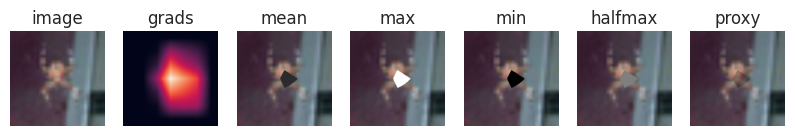

In [77]:
plot_grid(method_outputs, ["image", "grads","mean", "max", "min", "halfmax", "proxy"], rows = 1, cols = 7)
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/methods.pdf")

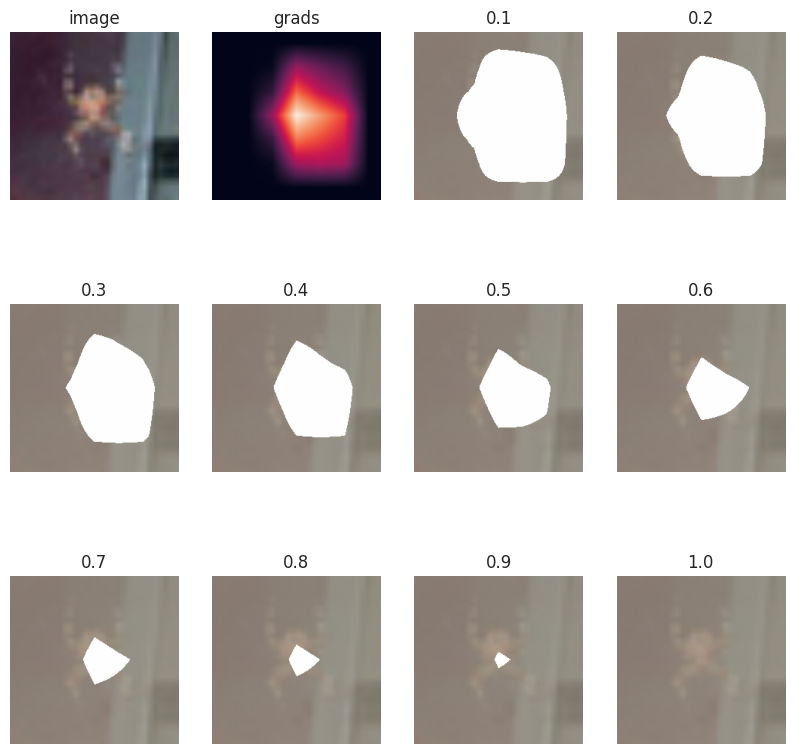

In [78]:
plot_grid(output_list, threshold_test, rows = 3)
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/grad_threshold.pdf")

# Explanability test

In [81]:
def plot_images_grad(image, grads, title,weight = 0.6, figsize=(10,10)):

    cams = [show_cam_on_image(image[i], grads[i], weight) for i in range(len(image))]
    rows = 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i in range(rows):
        for j in range(cols):
            img_index = i*cols + j
            if img_index < len(cams):
                axes[i][j].imshow(cams[img_index])
                axes[i][j].set_title(title[img_index])
            axes[i][j].axis('off')
    # plt.show()
    return plt



In [84]:
read_agg_res["label_map"]

0     {0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...
1     {0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...
2     {0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...
3     {0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...
4     {0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...
                            ...                        
83    {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...
84    {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...
85    {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...
86    {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...
87    {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...
Name: label_map, Length: 81, dtype: object

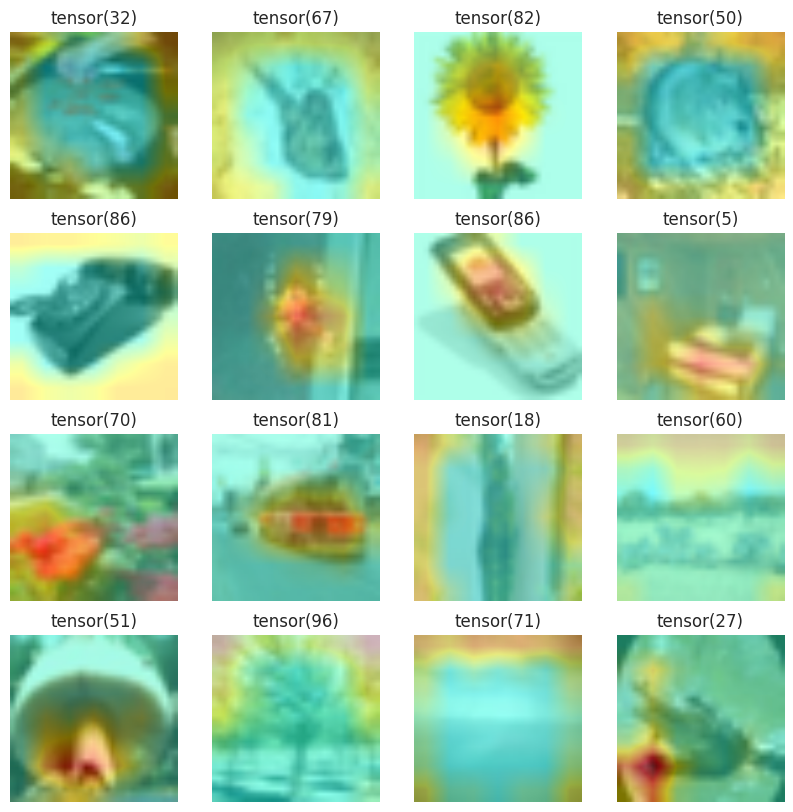

In [82]:
plot_images_grad(image, grads_1, label)
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/proxy.pdf")

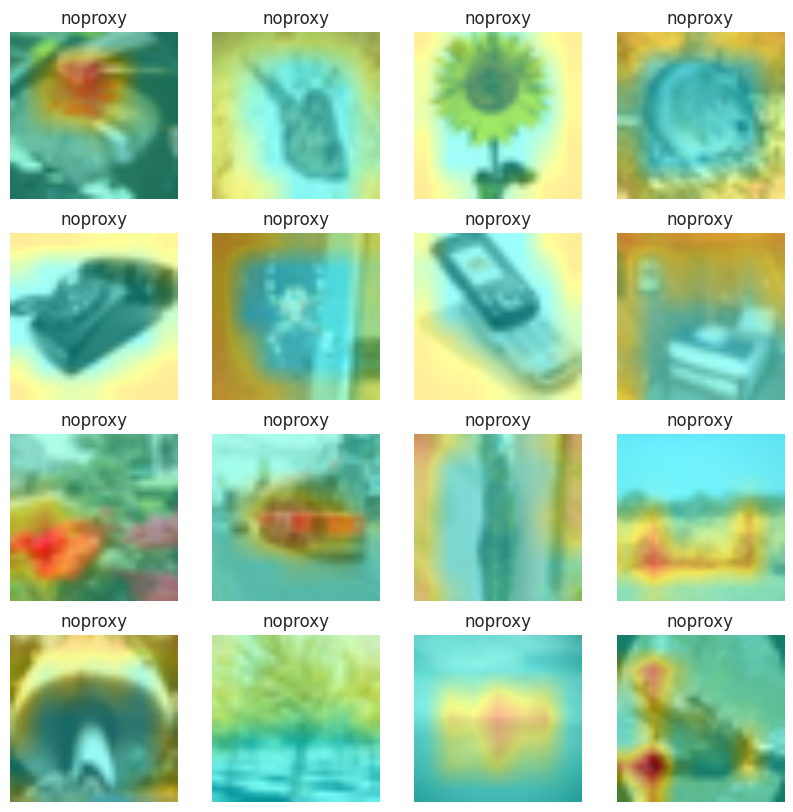

In [80]:
plot_images_grad(image, grads_2, "noproxy")
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/noproxy.pdf")